In [1]:
import pandas as pd, numpy as np
np.set_printoptions(suppress=True)# 关掉科学计数法
import glob
import os
import csv
# 一次性merge多个pct_chg
from functools import reduce
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels import regression

# import yfinance as yf
import tushare as ts
import time, urllib
ts.set_token('8ef5ec61cdd848715c57c11d58dd71da1271f76b2420d2bac8aef123')
pro = ts.pro_api('8ef5ec61cdd848715c57c11d58dd71da1271f76b2420d2bac8aef123')

import matplotlib
import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif']=['KaiTi']
# plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns
%matplotlib inline
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)


from plotly.graph_objs import Scatter,Layout
import plotly
import plotly.offline as py
import numpy as np
import plotly.graph_objs as go

#setting offilne
plotly.offline.init_notebook_mode(connected=True)

In [2]:
matplotlib.matplotlib_fname()

'/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/matplotlib/mpl-data/matplotlibrc'

In [3]:
ch_db_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"

In [4]:
data = pro.query('stock_basic', exchange='', list_status='L', fields='ts_code,symbol,industry')

In [102]:
data

,ts_code,symbol,industry
0,000001.SZ,000001,银行
1,000002.SZ,000002,全国地产
2,000004.SZ,000004,生物制药
3,000005.SZ,000005,环境保护
4,000006.SZ,000006,区域地产
...,...,...,...
3784,688388.SH,688388,元器件
3785,688389.SH,688389,医疗保健
3786,688396.SH,688396,元器件
3787,688398.SH,688398,矿物制品


In [5]:
tickers = list(data['ts_code'].unique())

In [6]:
def get_mkt_data_df(path, ticker_list, date_col):
    # e.g. ch_db_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
    csv_path = path+"*.csv"
    files = glob.glob(csv_path)
    ticker_df_list = []
    for ticker in ticker_list:
        try:
            ticker_df = pd.read_csv(path+ticker+".csv")
            ticker_df = ticker_df.sort_values(date_col)
            ticker_df = ticker_df[ticker_df['trade_date']>'2018-01-01']
            ticker_df_list.append(ticker_df) 
        except Exception as e:
            print(e)
    try:
        tickers_data_concated = pd.concat(ticker_df_list)
        tickers_data_concated.reset_index(inplace=True)
        del tickers_data_concated['index']  
    except Exception as e:
        print(e)
    return tickers_data_concated

In [7]:
stocks = get_mkt_data_df(ch_db_path, tickers, 'trade_date')

[Errno 2] File b'/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/002973.SZ.csv' does not exist: b'/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/002973.SZ.csv'


In [11]:
stocks

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000001.SZ,2018-01-02,13.0003,13.5651,12.9710,13.3411,12.9516,0.3895,3.0074,2081592.55,2856543.822
1,000001.SZ,2018-01-03,13.3703,13.4969,12.8542,12.9808,13.3411,-0.3603,-2.7007,2962498.38,4006220.766
2,000001.SZ,2018-01-04,12.9710,13.0197,12.7860,12.9029,12.9808,-0.0779,-0.6001,1854509.48,2454543.516
3,000001.SZ,2018-01-05,12.8639,13.0003,12.8055,12.9516,12.9029,0.0487,0.3774,1210312.72,1603289.517
4,000001.SZ,2018-01-08,12.9029,12.9418,12.5231,12.6205,12.9516,-0.3311,-2.5564,2158620.81,2806099.169
...,...,...,...,...,...,...,...,...,...,...,...
1849095,688399.SH,2020-03-02,95.1000,95.8000,86.4300,93.4300,95.5000,-2.0700,-2.1675,23058.59,212633.002
1849096,688399.SH,2020-03-03,93.8000,96.8800,90.4800,93.6000,93.4300,0.1700,0.1820,23624.85,220497.128
1849097,688399.SH,2020-03-04,92.5000,94.9800,89.2300,90.9900,93.6000,-2.6100,-2.7885,15560.02,141998.485
1849098,688399.SH,2020-03-05,91.9700,91.9900,88.1200,89.2500,90.9900,-1.7400,-1.9123,12587.72,112483.939


In [8]:
# 接下来需要找出每个industry中，mkt cap最大的

In [14]:
def vol_ewm(vol_series, window_span):
    vol_mean = vol_series.ewm(span = window_span).mean()
    return vol_mean

def add_vol_ewm_col(df, code_col, vol_col, window_span):
    vol_col_rename = str(window_span)+"_vol_ewm"
    df[vol_col_rename] = df.groupby([code_col])[vol_col].apply(lambda x: vol_ewm(x, window_span))
    return df

In [15]:
stocks

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000001.SZ,2018-01-02,13.0003,13.5651,12.9710,13.3411,12.9516,0.3895,3.0074,2081592.55,2856543.822
1,000001.SZ,2018-01-03,13.3703,13.4969,12.8542,12.9808,13.3411,-0.3603,-2.7007,2962498.38,4006220.766
2,000001.SZ,2018-01-04,12.9710,13.0197,12.7860,12.9029,12.9808,-0.0779,-0.6001,1854509.48,2454543.516
3,000001.SZ,2018-01-05,12.8639,13.0003,12.8055,12.9516,12.9029,0.0487,0.3774,1210312.72,1603289.517
4,000001.SZ,2018-01-08,12.9029,12.9418,12.5231,12.6205,12.9516,-0.3311,-2.5564,2158620.81,2806099.169
...,...,...,...,...,...,...,...,...,...,...,...
1849095,688399.SH,2020-03-02,95.1000,95.8000,86.4300,93.4300,95.5000,-2.0700,-2.1675,23058.59,212633.002
1849096,688399.SH,2020-03-03,93.8000,96.8800,90.4800,93.6000,93.4300,0.1700,0.1820,23624.85,220497.128
1849097,688399.SH,2020-03-04,92.5000,94.9800,89.2300,90.9900,93.6000,-2.6100,-2.7885,15560.02,141998.485
1849098,688399.SH,2020-03-05,91.9700,91.9900,88.1200,89.2500,90.9900,-1.7400,-1.9123,12587.72,112483.939


In [16]:
last_date = stocks['trade_date'].values[0]
vol_rolling_window = 252
tgt_pos_vol_added_df = add_vol_ewm_col(stocks,'ts_code','vol',vol_rolling_window)
last_date = tgt_pos_vol_added_df['trade_date'].values[-1]
last_date_tgt_pos_vol_added_df = tgt_pos_vol_added_df[tgt_pos_vol_added_df['trade_date']==last_date]

In [17]:
vol_ewm_col = "{}_vol_ewm".format(vol_rolling_window)
max_capacity_pct = 0.05
last_date_tgt_pos_vol_added_df['max_value_capacity'] = last_date_tgt_pos_vol_added_df[vol_ewm_col]\
                                                         *max_capacity_pct*100*last_date_tgt_pos_vol_added_df['close']
last_date_tgt_pos_vol_added_df.sort_values("max_value_capacity", ascending=False, inplace=True)

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/pandas/compat/_optional.py:106: UserWarning:

Pandas requires version '2.6.2' or newer of 'numexpr' (version '2.6.1' currently installed).

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
data_all = last_date_tgt_pos_vol_added_df.merge(data, on= 'ts_code')

In [19]:
data_all['rank'] = data_all.groupby(['industry'])['252_vol_ewm'].rank(ascending = False)

In [20]:
data_all[data_all['industry']=="保险"]

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,252_vol_ewm,max_value_capacity,symbol,industry,rank
1,601318.SH,2020-03-06,81.57,81.92,80.80,80.91,82.45,-1.54,-1.8678,584186.07,4739601.763,627163.666437,2.537191e+08,601318,保险,2.0
130,601601.SH,2020-03-06,33.02,33.24,32.59,32.68,33.49,-0.81,-2.4186,299117.33,982079.918,235932.328388,3.855134e+07,601601,保险,3.0
150,601336.SH,2020-03-06,46.57,46.76,46.00,46.04,47.12,-1.08,-2.2920,147999.78,685067.605,155301.357744,3.575037e+07,601336,保险,4.0
252,601319.SH,2020-03-06,7.22,7.27,7.11,7.13,7.34,-0.21,-2.8610,1205228.90,863958.998,709081.309798,2.527875e+07,601319,保险,1.0
296,601628.SH,2020-03-06,30.61,30.83,30.42,30.58,30.98,-0.40,-1.2912,141246.25,432025.630,147566.547339,2.256293e+07,601628,保险,5.0
1550,600291.SH,2020-03-06,8.18,8.24,8.02,8.05,8.41,-0.36,-4.2806,248059.56,201111.253,136851.757385,5.508283e+06,600291,保险,7.0
1837,000627.SZ,2020-03-06,6.18,6.26,6.12,6.19,6.29,-0.10,-1.5898,187835.15,116059.484,140848.163815,4.359251e+06,000627,保险,6.0


In [21]:
industry_leaders = data_all[data_all['rank']==1]

In [22]:
industry_leaders

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,252_vol_ewm,max_value_capacity,symbol,industry,rank
0,000063.SZ,2020-03-06,50.52,51.30,50.02,50.86,51.91,-1.05,-2.0227,965455.33,4895831.044,1.073918e+06,2.730973e+08,000063,通信设备,1.0
3,300059.SZ,2020-03-06,19.60,19.83,19.16,19.17,20.17,-1.00,-4.9579,3577782.52,6953359.990,2.213051e+06,2.121210e+08,300059,证券,1.0
4,000725.SZ,2020-03-06,5.02,5.28,4.98,5.16,5.10,0.06,1.1765,11874139.10,6116909.327,8.191343e+06,2.113366e+08,000725,元器件,1.0
6,000858.SZ,2020-03-06,132.00,134.88,130.00,130.07,133.20,-3.13,-2.3498,291658.22,3845033.468,2.766710e+05,1.799330e+08,000858,白酒,1.0
12,601816.SH,2020-03-06,7.07,7.08,7.00,7.03,7.17,-0.14,-1.9526,1555059.23,1093483.648,3.821375e+06,1.343213e+08,601816,铁路,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2718,002210.SZ,2020-03-06,1.22,1.23,1.21,1.22,1.24,-0.02,-1.6129,172862.81,21100.440,3.617526e+05,2.206691e+06,002210,仓储物流,1.0
2759,600555.SH,2020-03-06,2.43,2.55,2.41,2.44,2.51,-0.07,-2.7888,248059.00,61133.847,1.755146e+05,2.141278e+06,600555,旅游服务,1.0
2812,600662.SH,2020-03-06,4.16,4.24,4.14,4.19,4.18,0.01,0.2392,123946.30,51991.067,9.801511e+04,2.053416e+06,600662,公共交通,1.0
2979,600187.SH,2020-03-06,2.52,2.54,2.48,2.52,2.55,-0.03,-1.1765,194876.29,48991.548,1.408289e+05,1.774444e+06,600187,水务,1.0


In [23]:
# industry_leaders[industry_leaders['max_value_capacity']>=10000000]

In [89]:
import pylab as pl
sns.set(font_scale=1.2,font='STSong')
import matplotlib.font_manager as fm
def draw_risk_parity_pie(x, lables, title):
    fonts = fm.FontProperties(fname='STHeiti-Medium.ttc')
    # 保证圆形
    plt.figure(1, figsize = (20, 18))
#     plt.rcParams['font.sans-serif']=['STSong']     ## 中文宋体
    plt.axes(aspect=1)
#     zhfont1 = matplotlib.font_manager.FontProperties(fname='STHeiti-Medium.ttc')
    plt.pie(x=x, labels=lables, autopct='%3.1f %%')
#     plt.legend('x-变量',fontproperties=fonts,fontsize=24)
#     plt.xlabel(u"横坐标xlabel",fontproperties=fonts)
    plt.title(title, fontsize = 15)
#     plt.rcParams['font.sans-serif']=['SimHei']
#     plt.rcParams['axes.unicode_minus'] = False
    
    plt.show()

In [90]:
x = industry_leaders['252_vol_ewm']
title = industry_leaders['symbol']

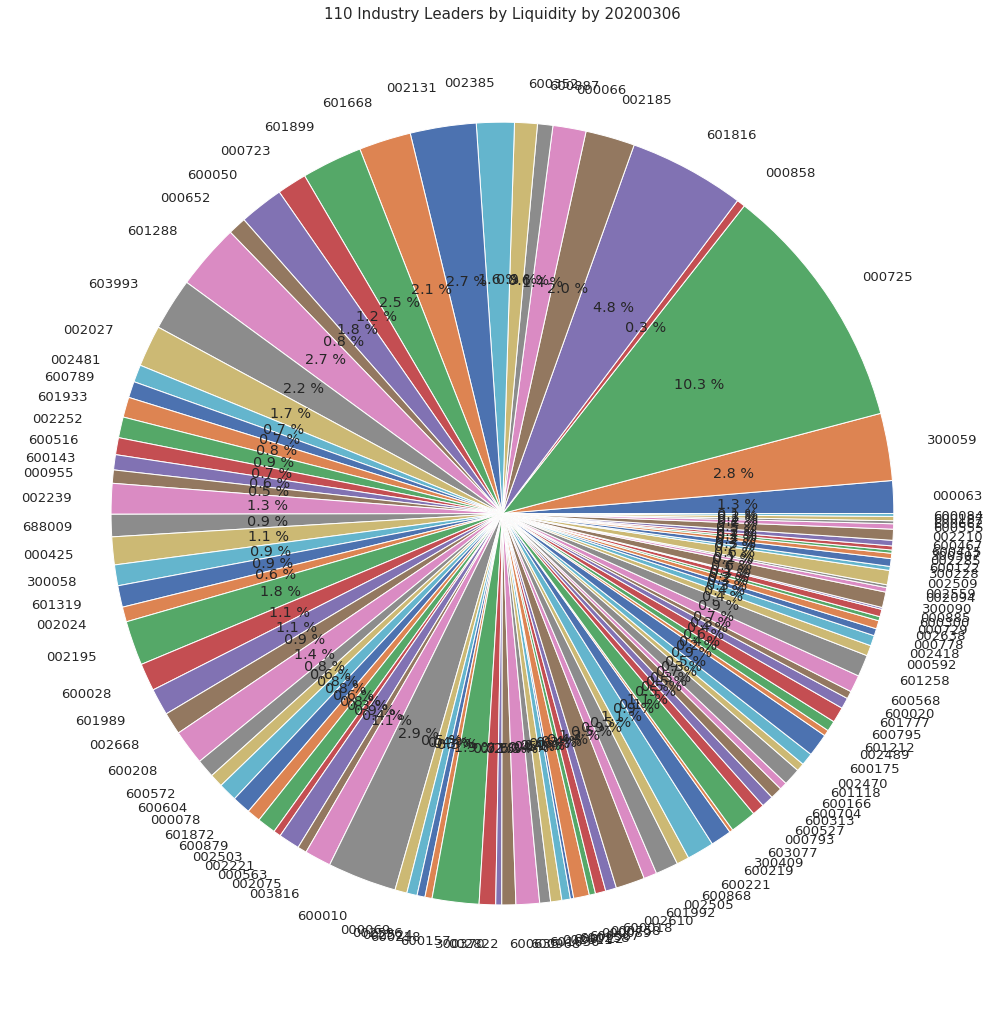

In [91]:
draw_risk_parity_pie(x, title, "110 Industry Leaders by Liquidity by 20200306")

In [101]:
industry_leaders[['trade_date','252_vol_ewm','industry','rank','ts_code']].sort_values("252_vol_ewm", ascending = False).head(50).reset_index()

,index,trade_date,252_vol_ewm,industry,rank,ts_code
0,4,2020-03-06,8.191343e+06,元器件,1.0,000725.SZ
1,12,2020-03-06,3.821375e+06,铁路,1.0,601816.SH
2,600,2020-03-06,2.272558e+06,普钢,1.0,600010.SH
3,3,2020-03-06,2.213051e+06,证券,1.0,300059.SZ
4,89,2020-03-06,2.168625e+06,互联网,1.0,002131.SZ
5,136,2020-03-06,2.157956e+06,银行,1.0,601288.SH
6,108,2020-03-06,1.991821e+06,黄金,1.0,601899.SH
7,138,2020-03-06,1.722109e+06,小金属,1.0,603993.SH
8,95,2020-03-06,1.711885e+06,建筑工程,1.0,601668.SH
9,21,2020-03-06,1.621137e+06,半导体,1.0,002185.SZ
